# Q0 <-> Q5 (coupler) <-> Q1 <-> Q2, Q1 <-> Q3 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import numpy.linalg as alg
import scqubits as scq
import sys
sys.path.insert(0, '..')
from QSwitch import QSwitchTunableTransmonCoupler
from tqdm import tqdm

In [2]:
import scipy.constants as cst
hbar = cst.hbar
h = cst.h
qe = cst.e
flux_quant = h/2/qe
red_flux_quant = hbar/2/qe 

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0
print(qe)

1.602176634e-19


In [3]:
def EC_GHz_from_C_fF(C_fF):
    return 1e-9 * qe**2 / (2*h*C_fF*1e-15)
def C_fF_from_EC_GHz(EC_GHz):
    return qe**2 / (1e9 * EC_GHz * 2*h*1e-15)

def LJ_H_from_EJ_GHz(EJ_GHz):
    return flux_quant**2 / (h*4*np.pi**2*EJ_GHz*1e9)

In [4]:
# fwidth = how fat the dolan junction finger is (um)
# jc = critical current density in uA/um^2
# jwidth = as fabricated dolan junction gap width (0.2 um)
def EJ_from_JJ_width(fwidth, jc, jwidth=0.2):
    I0_A = jc*jwidth*fwidth*1e-6
    Ej_GHz = 1e-9*red_flux_quant*I0_A/h
    return Ej_GHz

### Set qubit params

In [5]:
# Q3D VALUES
# All in SI units
# Q0 (10): switch, Q1 (2): in, Q2 (4): out1, Q3 (5): out2, Q4 (c2): coupler
# 10, 2, 4, 5, c2
# GOOD

# --- 4QC --- #
Cjs =   np.array([85.71, 88.4, 77.2, 75.18, 37]) # fF
Crqs =  np.array([6.93, 8.87, 5.26, 5.21, 3.62, 0.202]) # qubit to resonator, last two are coupler pad closer to Q0 -> res, coupler pad closer to Q1 -> res
C04 =   12.18 # between Q0 and coupler pad closer to Q0
C041 =  0.55 # between Q0 and coupler pad farther from Q1
C41 =   10.18 # between Q1 and coupler pad closer to Q1
C410 =  0.6 # between Q1 and coupler pad farther from Q1
C01 =   0.065 # direct (parasitic) capacitance between Q0/Q1
Cg =    126.5 # between each coupler pad and ground

C121 =  11.43 # between Q1 and Q1/Q2 capacitance bridge
C122 =  12.13 # between Q2 and Q1/Q2 capacitance bridge
C12g =  77.34 # between Q1/Q2 capacitance bridge and ground
C12 =   0.145 # direct (parasitic) capacitance between Q1/Q2
C131 =  11.15 # between Q1 and Q1/Q3 capacitance bridge
C133 =  11.46 # between Q3 and Q1/Q3 capacitance bridge
C13g =  78.94 # between Q1/Q3 capacitance bridge and ground
C13 =   0.119 # direct (parasitic) capacitance between Q1/Q3
C23 =   0.098 # direct (parasitic) capacitance between Q2/Q3

# resonators
res_freqs = np.array([6.28, 5.72, 6.53, 6.82, 5.5]) # GHz

jj_widths = np.array([1.360, 1.410, 1.610, 1.660, 0.750, 0.405]) # um
# jj_widths = np.array([1.510, 1.565, 1.790, 1.845, 0.835, 0.450]) # um (jc down)
# jj_widths = np.array([1.235, 1.280, 1.465, 1.510, 0.685, 0.370]) # um (jc up)

# # --- 2QC --- #
# Cjs =   np.array([87.18, 107.4, 100, 100, 37]) # fF
# Crqs =  np.array([6.93, 8.87, 10, 10, 3.62, 0.202]) # qubit to resonator, last two are coupler pad closer to Q0 -> res, coupler pad closer to Q1 -> res
# C04 =   12.23 # between Q0 and coupler pad closer to Q0
# C041 =  0.59 # between Q0 and coupler pad farther from Q1
# C41 =   10.2 # between Q1 and coupler pad closer to Q1
# C410 =  0.55 # between Q1 and coupler pad farther from Q1
# C01 =   0.078 # direct (parasitic) capacitance between Q0/Q1
# Cg =    127.5 # between each coupler pad and ground

# C121 =  0 # between Q1 and Q1/Q2 capacitance bridge
# C122 =  0 # between Q2 and Q1/Q2 capacitance bridge
# C12g =  100 # between Q1/Q2 capacitance bridge and ground
# C12 =   0 # direct (parasitic) capacitance between Q1/Q2
# C131 =  0 # between Q1 and Q1/Q3 capacitance bridge
# C133 =  0 # between Q3 and Q1/Q3 capacitance bridge
# C13g =  100 # between Q1/Q3 capacitance bridge and ground
# C13 =   0 # direct (parasitic) capacitance between Q1/Q3

# # resonators
# res_freqs = np.array([6.25, 5.70, 0, 0, 5.485]) # GHz

# jj_widths = np.array([1.410, 1.410, 1.0, 1.0, 0.685, 0.370]) # um
# # jj_widths = np.array([1.565, 1.565, 1.0, 1.0, 0.765, 0.410]) # um (jc down)
# # jj_widths = np.array([1.280, 1.280, 1.0, 1.0, 0.625, 0.335]) # um (jc up)


# ------ #
# drive line capacitances
Cds = np.array([50, 65, 40, 40, 50])*1e-18 # aF -> F

# calculate Ej from jj widths
jc = 0.1 # uA/um^2
EJs_targets = EJ_from_JJ_width(jj_widths, jc=jc)
EJ1, EJ2 = EJs_targets[-2:]
EJs_targets[-2] = EJ1 + EJ2
dEJ = (EJ1 - EJ2)/(EJ1 + EJ2)
EJs_targets = EJs_targets[:-1]
print('EJs', EJs_targets)
print('dEJ', dEJ)
# EJs_targets = np.array([13.5, 14, 16, 16.5, 11.5]) # GHz -> this is the total Ej of the squid, = EJ1+EJ2 
# dEJ = 0.3 # (EJ1 - EJ2)/(EJ1 + EJ2)


# GET ZO FROM CPW MATHEMATICA
Zo = 52.7066 # Ohm

EJs [13.50979149 14.006475   15.99320905 16.48989256 11.4733891 ]
dEJ 0.2987012987012987


In [6]:
# Variable transformation to combine nodes 1 and 2 to get differential mode describing the tunable coupler
S = np.identity(9)
norm = 1
S[1, 1] = 1 * norm
S[1, 2] = 1 * norm
S[2, 1] = 1 * norm
S[2, 2] = -1 * norm
# print(S)
# print(alg.inv(S))

In [7]:
EJ1 = EJs_targets[-1] * (dEJ + 1)/2
EJ2 = EJs_targets[-1] * (1 - dEJ)/2

Ljs = LJ_H_from_EJ_GHz(EJs_targets)
Lj41 = LJ_H_from_EJ_GHz(EJ1)
Lj42 = LJ_H_from_EJ_GHz(EJ2)
print(f'Ljs Q0-Q4 (nH):', *(1e9*Ljs[:-1]))
print(f'Ljs SQUID (nH):', 1e9*Lj41, 1e9*Lj42)

c_matrix = np.zeros((9, 9))
c_matrix[0, 1] = -C04
c_matrix[0, 2] = -C041
c_matrix[0, 3] = -C01
c_matrix[0, 8] = -Cjs[0]
c_matrix[1, 2] = -Cjs[4]
c_matrix[1, 3] = -C410
c_matrix[1, 8] = -Cg
c_matrix[2, 3] = -C41
c_matrix[2, 8] = -Cg
c_matrix[3, 4] = -C131
c_matrix[3, 5] = -C121
c_matrix[3, 6] = -C12
c_matrix[3, 7] = -C13
c_matrix[3, 8] = -Cjs[1]
c_matrix[4, 7] = -C133
c_matrix[4, 8] = -C13g
c_matrix[5, 6] = -C122
c_matrix[5, 8] = -C12g
c_matrix[6, 7] = -C23
c_matrix[6, 8] = -Cjs[2]
c_matrix[7, 8] = -Cjs[3]

c_matrix += c_matrix.transpose()
for i in range(len(c_matrix)):
    c_matrix[i, i] = -sum(c_matrix[i, :])

# add the capacitances to the resonators
c_matrix[0, 0] += Crqs[0]
c_matrix[3, 3] += Crqs[1]
c_matrix[6, 6] += Crqs[2]
c_matrix[7, 7] += Crqs[3]
c_matrix[1, 1] += Crqs[4]
c_matrix[2, 2] += Crqs[5]

c_matrix = alg.inv(S.transpose()) @ c_matrix @ alg.inv(S) # basis transformation to use differential mode
print('Check symmetric capacitances:', np.allclose(c_matrix*1e15, c_matrix.T*1e15))
c_matrix = c_matrix[:-1, :-1]

np.set_printoptions(suppress=True, precision=10)

q_nodes = [0, 3, 6, 7, 2] # nodes in circuit diagram referring to Q0-4 and differential coupler (Q5) that was originally (node 1 - node 2)/sqrt(2)

print('Capacitance matrix diagonal elements for Q0-4 and Q5 (differential) (10 digits precision) (fF)\n', c_matrix.diagonal()[q_nodes])

q01c_nodes = [0, 3, 2]
print('Coupling cap for Q0, Q1, Qc (10 digits precision) (fF):\n', c_matrix[q01c_nodes][:, q01c_nodes])
print('Coupling cap for Q0-5 (10 digits precision) (fF):\n', c_matrix[q_nodes][:, q_nodes])
c_matrix *= 1e-15
Crqs *= 1e-15


# Use the post variable transformed nodes for this to get EJ right for the squid loop, so don't apply the basis transformation!
inv_l_matrix = np.zeros((9, 9))
inv_l_matrix[0, 8] = -1/Ljs[0]
# inv_l_matrix[1, 2] = -1/Lj41 - 1/Lj42
inv_l_matrix[2, 8] = -1/Lj41 - 1/Lj42
inv_l_matrix[3, 8] = -1/Ljs[1]
inv_l_matrix[6, 8] = -1/Ljs[2]
inv_l_matrix[7, 8] = -1/Ljs[3]
inv_l_matrix += inv_l_matrix.transpose()
for i in range(len(inv_l_matrix)):
    inv_l_matrix[i, i] = -sum(inv_l_matrix[i, :])
# print(inv_l_matrix)
# inv_l_matrix = alg.inv(S.transpose()) @ inv_l_matrix @ alg.inv(S) # basis transformation to use differential mode
inv_l_matrix = inv_l_matrix[:-1, :-1]


print('Check symmetric capacitances:', np.allclose(c_matrix*1e15, c_matrix.T*1e15))
print('Check symmetric inductances:', np.allclose(inv_l_matrix, inv_l_matrix.T, rtol=1e5))
print('Full c_matrix:\n', c_matrix*1e15)
print('Shapes', c_matrix.shape, inv_l_matrix.shape)

Ljs Q0-Q4 (nH): 12.099484502774013 11.670424768633096 10.22068256134948 9.912830676971483
Ljs SQUID (nH): 21.940398565030215 40.63036771301893
Check symmetric capacitances: True
Capacitance matrix diagonal elements for Q0-4 and Q5 (differential) (10 digits precision) (fF)
 [105.435 130.959  94.833  92.067 107.083]
Coupling cap for Q0, Q1, Qc (10 digits precision) (fF):
 [[105.435  -0.065  -5.815]
 [ -0.065 130.959   4.79 ]
 [ -5.815   4.79  107.083]]
Coupling cap for Q0-5 (10 digits precision) (fF):
 [[105.435  -0.065   0.      0.     -5.815]
 [ -0.065 130.959  -0.145  -0.119   4.79 ]
 [  0.     -0.145  94.833  -0.098   0.   ]
 [  0.     -0.119  -0.098  92.067   0.   ]
 [ -5.815   4.79    0.      0.    107.083]]
Check symmetric capacitances: True
Check symmetric inductances: True
Full c_matrix:
 [[105.435  -6.365  -5.815  -0.065   0.      0.      0.      0.   ]
 [ -6.365  70.083   1.367  -5.39    0.      0.      0.      0.   ]
 [ -5.815   1.367 107.083   4.79    0.      0.      0.     

# BEGIN ANALYSIS

In [8]:
inv_c_matrix = alg.inv(c_matrix)

ECs = qe**2/2/h * inv_c_matrix
EJs = flux_quant**2/h/4/np.pi**2 * inv_l_matrix
Zs = np.sqrt(8*np.diag(ECs)/np.diag(EJs))
gs = np.array([[4*ECs[i,j]/np.sqrt(Zs[i]*Zs[j]) for i in range(len(c_matrix))] for j in range(len(c_matrix))])
print('Check symmetric:', np.allclose(gs, gs.T))

print('Index (node) for Qi:', q_nodes)
print('Qubit print order: Q0, Q1, Q2, Q3, Q4 (TC)')
ECs = 1e-9*np.diag(ECs)[q_nodes]
EJs = 1e-9*np.diag(EJs)[q_nodes]
print('qubit ECs (GHz)\n', ECs)
print('qubit EJs (GHz)\n', EJs)
# print('all q-q gs (MHz)\n', 1e-6*gs)
print('q-q gs (MHz)\n', 1e-6*gs[q_nodes][:, q_nodes])
gs = 1e-9 * np.array([gs[0,3], gs[3,6], gs[3,7], gs[0,6], gs[0,7], gs[6,7], gs[0,2], gs[3,2], gs[6,2], gs[7,2]]) # gs=[01, 12, 13, 02, 03, 23, 0c, 1c, 2c, 3c]

print('impedances (unitless)\n', *Zs[q_nodes])


"""
For each col, find row with max value, which is the node that it has the most population.
-> use node_pos to reference in EC, EJ
"""
evals_c, u1 = alg.eigh(inv_c_matrix)
u1 = np.array([u1[i]/np.sqrt(evals_c[i]) for i in range(len(evals_c))])
evals, evecs = alg.eigh(u1.transpose() @ inv_l_matrix @ u1)

node_pos = np.array([np.argmax(np.abs(evecs[:, i])) for i in range(len(c_matrix))])
node_counts = np.zeros_like(node_pos)
for m in range(len(c_matrix)):
    node_counts[m] += 1
if any(node_counts != 1): assert False, "Bad mapping of evecs to modes"
print()
print('Qubit modes are mapped (n_evec: n_node):', node_pos)
print('Modes (cols are evecs)\n', np.around(evecs, 3))


# AFTER HERE EVERYTHING IS INDEXED SO QUBIT NUMBER = INDEX AND EVERYTHING IS IN GHz


Check symmetric: False
Index (node) for Qi: [0, 3, 6, 7, 2]
Qubit print order: Q0, Q1, Q2, Q3, Q4 (TC)
qubit ECs (GHz)
 [0.1852657792 0.151620009  0.207486549  0.2134254825 0.1817733532]
qubit EJs (GHz)
 [13.5097914931 14.0064750039 15.993209047  16.4898925578 11.4733890989]
q-q gs (MHz)
 [[2237.3654360503    5.4681789093    0.0851071567    0.0794345772
   114.4898779143]
 [   5.4681789093 2060.9036203428   32.0760622954   29.9381220626
   -85.3952399266]
 [   0.0851071567   32.0760622954 2576.1893379737    3.2483362464
    -1.3290980755]
 [   0.0794345772   29.9381220626    3.2483362464 2653.0598467619
    -1.2405107601]
 [ 114.4898779143  -85.3952399266   -1.3290980755   -1.2405107601
  2042.330242385 ]]
impedances (unitless)
 0.3312213126588697 0.2942786989258342 0.3221604032563389 0.32178012530582545 0.3560116761966201

Qubit modes are mapped (n_evec: n_node): [6 7 2 6 1 5 0 1]
Modes (cols are evecs)
 [[-0.382 -0.148  0.051  0.067  0.133  0.076  0.896 -0.012]
 [ 0.1    0.146 -0.057

 C:\Users\slab\AppData\Local\Temp\ipykernel_26660\3794587789.py: 5RuntimeWarning: invalid value encountered in sqrt
 C:\Users\slab\AppData\Local\Temp\ipykernel_26660\3794587789.py: 5

In [10]:
cutoffs = [4, 4, 4, 4, 4]
isCavity = [False]*len(cutoffs)
phi_ext = 0

qram = QSwitchTunableTransmonCoupler(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    phi_ext=phi_ext,
    is2Q=False,
    cutoffs=cutoffs,
    useZZs=False,
)

qubit_freqs = np.array(qram.qubit_freqs)
alphas = qram.alphas
charge_mat_el = 1/np.sqrt(2) * (EJs/8/ECs)**1/4

print('EJ values (GHz):\n\t', end='')
print(*EJs, sep=', ')
print('EC values (GHz):\n\t', end='')
print(*ECs, sep=', ')
print('EJ/EC at 0 flux:\n\t', *([*EJs[:-1], qram.EJ_flux(EJs[-1], 0, dEJ)]/ECs))
print('EJ/EC at 0.5 flux:\n\t', *([*EJs[:-1], qram.EJ_flux(EJs[-1], 0.5, dEJ)]/ECs))
print('*******************')
print('qubit freqs/2pi (GHz):\n\t', *qubit_freqs)
print('alphas/2pi (GHz):\n\t', *alphas)
print('all gs at 0 flux (MHz) [01, 12, 13, 02, 03, 23, 0c, 1c, 2c, 3c]\n\t', end='')
print(*(1e3*gs), sep=', ')
print('q-q couplings at 0 flux: 01, 12, 13 (MHz)\n\t', *(gs[:3]*1e3))
delta_12 = qubit_freqs[1] - qubit_freqs[2]
delta_13 = qubit_freqs[1] - qubit_freqs[3]
print('q-q couplings at 0 flux 02, 03, 23 (MHz)\n\t', *(gs[3:6]*1e3))
print('q-q couplings at 0 flux 0c, 1c, 2c, 3c (MHz)\n\t', *(gs[6:]*1e3))
g_eff = 1 / (2*alphas[2]/(0.100*gs[1]*delta_12*(delta_12 - alphas[2])))
print('Q1/Q2 eg-gf 1/g_eff (0.100 GHz drive_strength) (ns)\n\t', 1/g_eff, '\tg_eff (MHz):', 1e3*g_eff)
g_eff = 1 / (2*alphas[1]/(0.100*gs[1]*-delta_12*(-delta_12 - alphas[1])))
print('Q1/Q2 ge-fg 1/g_eff (0.100 GHz drive_strength) (ns)\n\t', 1/g_eff, '\tg_eff (MHz):', 1e3*g_eff)
g_eff = 1 / (2*alphas[3]/(0.100*gs[2]*delta_13*(delta_13 - alphas[3])))
print('Q1/Q3 eg-gf 1/g_eff (0.100 GHz drive_strength) (ns)\n\t', 1/g_eff, '\tg_eff (MHz):', 1e3*g_eff)
g_eff = 1 / (2*alphas[1]/(0.100*gs[2]*-delta_13*(-delta_13 - alphas[1])))
print('Q1/Q3 ge-fg 1/g_eff (0.100 GHz drive_strength) (ns)\n\t', 1/g_eff, '\tg_eff (MHz):', 1e3*g_eff)
print('*******************')

Crqs_diff = np.copy(Crqs)
Crqs_diff[-2] = Crqs[-2] + Crqs[-1]
Crqs_diff = Crqs[:-1]
Cqs = c_matrix.diagonal()[q_nodes]
print('Crqs (differential) (fF):\n\t', *1e15*Crqs_diff)
print('Cqs (fF):\n\t', *1e15*Cqs)
charge_mat_el = 1/np.sqrt(2) * (EJs/8/ECs)**1/4
# print(res_freqs)
g_rqs = Crqs_diff/(Crqs_diff+Cqs) * res_freqs * np.sqrt(2*Zo/(hbar/qe**2))
deltas = qubit_freqs-res_freqs
lamb_shifts = g_rqs**2/deltas
chi_shifts = g_rqs**2/deltas * alphas/(deltas+alphas)

kappa_res = 0.2e-3 # GHz
nth = 0.03 # BE 80 mK around 7 GHz
shot_rate = kappa_res/2*np.real(((1 + 2*1j*chi_shifts/kappa_res)**2 + 8j*chi_shifts*nth/kappa_res)**0.5 - 1)
drive_purcell_rate_analytical = (2*np.pi*qubit_freqs*1e9*Cds)**2/(Cqs+Cds) * 50 # /2/np.pi
# drive_purcell_rate_sim = qubit_freqs*1e9/Q_drives
# kappas = res_freqs/Q_res
kappas = np.array([kappa_res]*len(res_freqs))
res_purcell_rate = kappas * (g_rqs/deltas)**2

print('delta wq-wr (GHz) [want 1.5-2]:\n\t', *deltas)
print('g res/qubit (MHz):\n\t', *1e3*g_rqs)
print('lamb shifts (MHz):\n\t', *(1e3*lamb_shifts))
print('chi shifts at 0 flux (MHz) [want 0.15-0.5]:\n\t', *(1e3*chi_shifts))
print('chi/kappa at 0 flux [want about 0.5-2]:\n\t', *(chi_shifts/kappas))
print('qubit dephasing time from resonator shot rate (us):\n\t', *(1e-3/shot_rate))
print('\n')
print('drive purcell limits - analytical (ms) [want >1 ms]:\n\t', *(1e3/drive_purcell_rate_analytical))
# print('drive purcell limits - simulated (ms) [want >1 ms]:\n\t', *(1e3/drive_purcell_rate_sim))
# print('res linewidth kappas - simulated (kHz):\n\t', *(1e6*kappas))
print('res purcell time - simulated (s):\n\t', *(1/res_purcell_rate))

EJ values (GHz):
	13.509791493125586, 14.006475003902255, 15.99320904700896, 16.489892557785637, 11.473389098941208
EC values (GHz):
	0.18526577915654488, 0.15162000900150416, 0.2074865489965693, 0.21342548248372697, 0.18177335323463725
EJ/EC at 0 flux:
	 72.92113824059302 92.37880340558021 77.08070293883678 77.26299767902805 63.11920253862012
EJ/EC at 0.5 flux:
	 72.92113824059302 92.37880340558021 77.08070293883678 77.26299767902805 18.853787771276142
*******************
qubit freqs/2pi (GHz):
	 4.280807381205442 3.9639854594966764 4.9354961169480305 5.083042160488517 3.893662764157945
alphas/2pi (GHz):
	 -0.2067790411384216 -0.1668152682605193 -0.23075091166786876 -0.23732025661936973 -0.20493532131689918
all gs at 0 flux (MHz) [01, 12, 13, 02, 03, 23, 0c, 1c, 2c, 3c]
	5.468178909301609, 32.07606229544565, 29.938122062648034, 0.08510715668898039, 0.07943457715884845, 3.248336246352355, 114.48987791428445, -85.39523992660126, -1.3290980755153383, -1.2405107600647878
q-q couplings at 

# Tunable transmon

In [13]:
is2Q = False

In [11]:
from PulseSequence import PulseSequence
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyle_cycle=['solid', 'dashed', 'dotted', 'dashdot']
marker_cycle = [None, 'o', '.', 's', '*', '^']

In [12]:
import scqubits as scq
transmon = scq.TunableTransmon(EJmax=EJs[-1], EC=ECs[-1], d=dEJ, flux=0.5, ng=0, ncut=110)
transmon.t1_flux_bias_line(M=1.4e3)*1e-9*1e3

# transmon = scq.TunableTransmon(EJmax=20, EC=0.350, d=0.1, flux=0.5, ng=0, ncut=110)
# transmon.t1_flux_bias_line(M=140)*1e-9*1e3

See documentation for details.
This warning can be disabled by executing:
scqubits.settings.T1_DEFAULT_WARNING=False

 C:\Users\slab\AppData\Roaming\Python\Python39\site-packages\scqubits\core\noise.py: 1195

0.7501496335159072

In [14]:
cutoffs = [4]*5

print('AT FLUX 0')
phi_ext = 0.0
qram = QSwitchTunableTransmonCoupler(
    EJs=EJs,
    ECs=ECs,
    dEJ=dEJ,
    gs=gs,
    phi_ext=phi_ext,
    is2Q=is2Q,
    cutoffs=cutoffs,
    useZZs=False,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('bare qubit freqs (GHz)', *qubit_freqs)
print('bare alphas (GHz)', *alphas)
print(f'EJ/EC', *([*EJs[:-1], qram.EJ_flux(phi_ext=phi_ext)]/ECs))

# print('capacitances (fF)', *(qe**2/(2*h*np.array(ECs)*1e9)*1e15))
# print('lumped L (nH)', *(red_flux_quant**2/h/np.array(EJs)))

print()
print('AT FLUX 0.5')
phi_ext = 0.5
qram = QSwitchTunableTransmonCoupler(
    EJs=EJs,
    ECs=ECs,
    dEJ=dEJ,
    gs=gs,
    phi_ext=phi_ext,
    is2Q=False,
    cutoffs=cutoffs,
    useZZs=False,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('bare qubit freqs (GHz)', *qubit_freqs)
print('bare alphas (GHz)', *alphas)
print(f'EJ/EC', *([*EJs[:-1], qram.EJ_flux(phi_ext=phi_ext)]/ECs))


AT FLUX 0
bare qubit freqs (GHz) 4.280807381205442 3.9639854594966764 4.9354961169480305 5.083042160488517 3.893662764157945
bare alphas (GHz) -0.2067790411384216 -0.1668152682605193 -0.23075091166786876 -0.23732025661936973 -0.20493532131689918
EJ/EC 72.92113824059302 92.37880340558021 77.08070293883678 77.26299767902805 63.11920253862012

AT FLUX 0.5
bare qubit freqs (GHz) 4.280807381205442 3.9639854594966764 4.9354961169480305 5.083042160488517 2.033249092100573
bare alphas (GHz) -0.2067790411384216 -0.1668152682605193 -0.23075091166786876 -0.23732025661936973 -0.2748102789751039
EJ/EC 72.92113824059302 92.37880340558021 77.08070293883678 77.26299767902805 18.853787771276142


### Minimize ZZ

In [15]:
ZZ_01_flux = []
ZZ_01_fe_flux = []
ZZ_21_flux = []
ZZ_31_flux = []
ZZ_23_flux = []
phi_exts = np.linspace(-0.25, 0.75, num=61)
# phi_exts = np.linspace(-0.25, 0.75, num=21)
# phi_exts = np.linspace(0.0, 0.5, num=21)
# phi_exts = [0, 0.382]
# print(phi_exts)
evals_flux = []
esys_flux = []
qubit_freqs_v_flux = np.zeros(shape=(qram.nqubits, 2, len(phi_exts)))
plot_levels = ['efggg', 'gfggg']
plot_levels_wds = [[], []]

for i_phi, phi_ext_i in enumerate(tqdm(phi_exts)):
    # print('phi_ext', phi_ext_i)
    qram = QSwitchTunableTransmonCoupler(
        EJs=EJs,
        ECs=ECs,
        dEJ=dEJ,
        phi_ext=phi_ext_i,
        gs=gs,
        is2Q=is2Q,
        cutoffs=cutoffs,
        useZZs=False,
    )
    evals, evecs = qram.esys
    evals_flux.append(evals)
    esys_flux.append(qram.esys)
    ZZ_01_flux.append(qram.get_ZZ(1, 0, qA_state='e', qB_state='e'))
    ZZ_01_fe_flux.append(qram.get_ZZ(1, 0, qA_state='f', qB_state='e'))
    ZZ_21_flux.append(qram.get_ZZ(1, 2, qA_state='e', qB_state='e'))
    ZZ_31_flux.append(qram.get_ZZ(1, 3, qA_state='e', qB_state='e'))
    ZZ_23_flux.append(qram.get_ZZ(2, 3, qA_state='e', qB_state='e'))
    for q in range(5):
        gstate = 'ggggg'
        estate = gstate[:q] + 'e' + gstate[q+1:]
        fstate = gstate[:q] + 'f' + gstate[q+1:]
        qubit_freqs_v_flux[q][0][i_phi] = qram.get_base_wd(gstate, estate)
        qubit_freqs_v_flux[q][1][i_phi] = qram.get_base_wd(gstate, fstate)
        # print(qubit_freqs_v_flux)
    for i, level in enumerate(plot_levels):
        wds = plot_levels_wds[i]
        wds.append(qram.get_base_wd('ggggg', level))

ZZ_01_flux = np.array(ZZ_01_flux)
ZZ_21_flux = np.array(ZZ_21_flux)
ZZ_31_flux = np.array(ZZ_31_flux)
ZZ_23_flux = np.array(ZZ_23_flux)
ZZ_01_fe_flux = np.array(ZZ_01_fe_flux)
evals_flux = np.array(evals_flux)
qubit_freqs_v_flux = np.array(qubit_freqs_v_flux)
plot_levels_wds = np.array(plot_levels_wds)

100%|██████████| 61/61 [01:09<00:00,  1.14s/it]


Q0/Q1 e states ZZ (MHz)
	Min ZZ 0.011583036481965792 at phi_ext/phi0 0.6833333333333333
	Max ZZ 24.114218836007062 at phi_ext/phi0 0.0
Q0 e/Q1 f ZZ (MHz)
	Min ZZ 0.021420812723604854 at phi_ext/phi0 0.35
	Max ZZ -193.50858791816705 at phi_ext/phi0 -0.1
Q2/Q1 e states ZZ (MHz)
	Min ZZ 0.7998645535725046 at phi_ext/phi0 0.0
	Max ZZ 0.9526597808213744 at phi_ext/phi0 -0.25
Q3/Q1 e states ZZ (MHz)
	Min ZZ 0.5372504475511519 at phi_ext/phi0 0.0
	Max ZZ 0.6486758401669235 at phi_ext/phi0 -0.25
Q2/Q3 e states ZZ (MHz)
	Min ZZ -0.5011324173214149 at phi_ext/phi0 0.5
	Max ZZ -0.5046197517257767 at phi_ext/phi0 0.0


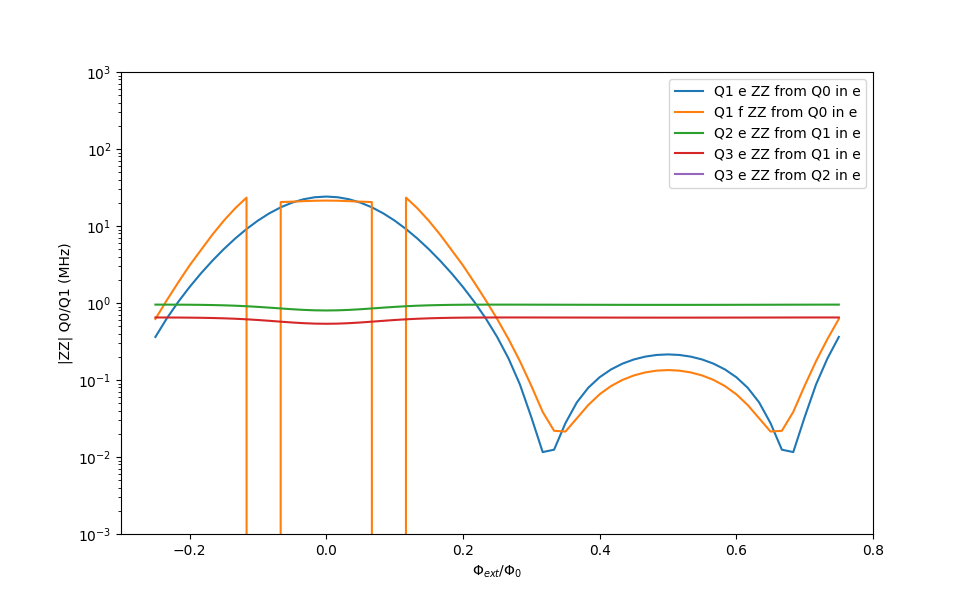

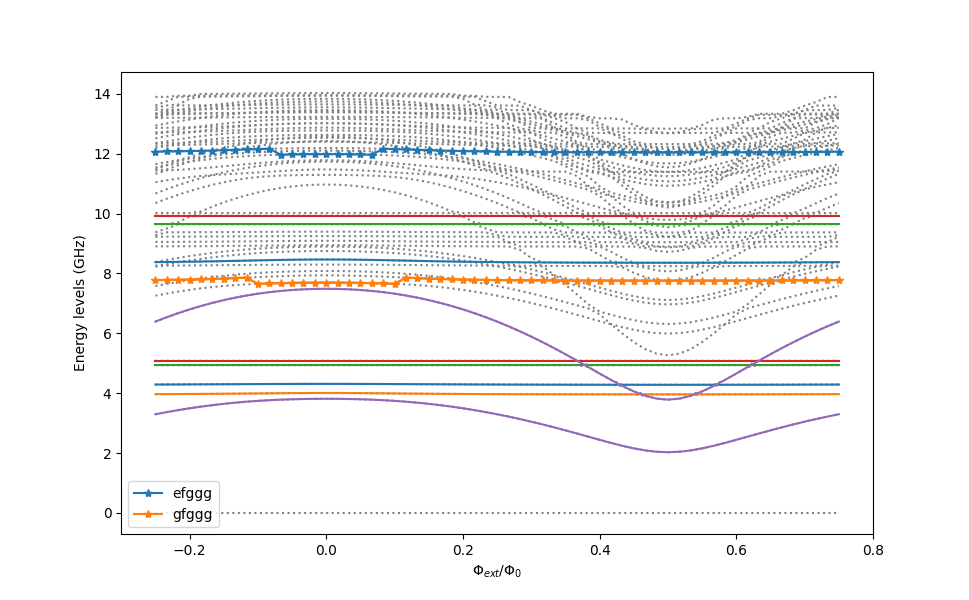

4.290744690540071
3.9702379874582685
3.2981216371909703


In [16]:
print('Q0/Q1 e states ZZ (MHz)')
i_flux_min_ZZ = np.argmin(np.abs(ZZ_01_flux))
print('\tMin ZZ', 1e3*ZZ_01_flux[i_flux_min_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_min_ZZ])
i_flux_max_ZZ = np.argmax(np.abs(ZZ_01_flux))
print('\tMax ZZ', 1e3*ZZ_01_flux[i_flux_max_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_max_ZZ])

print('Q0 e/Q1 f ZZ (MHz)')
i_flux_min_ZZ = np.argmin(np.abs(ZZ_01_fe_flux))
print('\tMin ZZ', 1e3*ZZ_01_fe_flux[i_flux_min_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_min_ZZ])
i_flux_max_ZZ = np.argmax(np.abs(ZZ_01_fe_flux))
print('\tMax ZZ', 1e3*ZZ_01_fe_flux[i_flux_max_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_max_ZZ])

print('Q2/Q1 e states ZZ (MHz)')
i_flux_min_ZZ = np.argmin(np.abs(ZZ_21_flux))
print('\tMin ZZ', 1e3*ZZ_21_flux[i_flux_min_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_min_ZZ])
i_flux_max_ZZ = np.argmax(np.abs(ZZ_21_flux))
print('\tMax ZZ', 1e3*ZZ_21_flux[i_flux_max_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_max_ZZ])

print('Q3/Q1 e states ZZ (MHz)')
i_flux_min_ZZ = np.argmin(np.abs(ZZ_31_flux))
print('\tMin ZZ', 1e3*ZZ_31_flux[i_flux_min_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_min_ZZ])
i_flux_max_ZZ = np.argmax(np.abs(ZZ_21_flux))
print('\tMax ZZ', 1e3*ZZ_31_flux[i_flux_max_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_max_ZZ])

print('Q2/Q3 e states ZZ (MHz)')
i_flux_min_ZZ = np.argmin(np.abs(ZZ_23_flux))
print('\tMin ZZ', 1e3*ZZ_23_flux[i_flux_min_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_min_ZZ])
i_flux_max_ZZ = np.argmax(np.abs(ZZ_23_flux))
print('\tMax ZZ', 1e3*ZZ_23_flux[i_flux_max_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_max_ZZ])

plt.figure()
plt.plot(phi_exts, abs(ZZ_01_flux)*1e3, label='Q1 e ZZ from Q0 in e')
plt.plot(phi_exts, ZZ_01_fe_flux*1e3, label='Q1 f ZZ from Q0 in e')
plt.plot(phi_exts, ZZ_21_flux*1e3, label='Q2 e ZZ from Q1 in e')
plt.plot(phi_exts, ZZ_31_flux*1e3, label='Q3 e ZZ from Q1 in e')
plt.plot(phi_exts, ZZ_23_flux*1e3, label='Q3 e ZZ from Q2 in e')
plt.axhline(0, linestyle='--', color='0.2')
plt.legend()
plt.ylim(1e-3, 1e3)
plt.yscale('log')
plt.xlabel('$\Phi_{ext}/\Phi_0$')
plt.ylabel('|ZZ| Q0/Q1 (MHz)')
plt.show()


plt.figure()
nlevels = 50
for level in range(nlevels):
    plt.plot(phi_exts, evals_flux[:, level]/2/np.pi, linestyle='dotted', color='0.5')
for q in range(len(qubit_freqs)):
    for level in range(qubit_freqs_v_flux.shape[1]):
            plt.plot(phi_exts, qubit_freqs_v_flux[q, level, :]/2/np.pi, default_colors[q])
for plot_level_name, wds in zip(plot_levels, plot_levels_wds):
    plt.plot(phi_exts, wds/2/np.pi, '*-', label=plot_level_name)
plt.legend()
plt.xlabel('$\Phi_{ext}/\Phi_0$')
plt.ylabel('Energy levels (GHz)')
plt.show()


print(qubit_freqs_v_flux[0, 0, 0]/2/np.pi)
print(qubit_freqs_v_flux[1, 0, 0]/2/np.pi)
print(qubit_freqs_v_flux[4, 0, 0]/2/np.pi)

# plt.figure()
# # plt.plot(phi_exts, wc_flux/2/np.pi, label='$f_{coupler}$')
# # plt.plot(phi_exts, dwcdflux/2/np.pi, label='$df_{coupler}/d\Phi$')
# plt.plot(phi_exts, 1e3*Omega_eff_flux, label='iSWAP $\Omega_{eff}$')
# # plt.plot(phi_exts, 1/(Del_0minus_flux * Del_1minus_flux))
# plt.axhline(0, linestyle='--', color='0.2')
# plt.xlabel('$\Phi_{ext}/\Phi_0$')
# plt.ylabel('iSWAP rate (MHz)')
# plt.legend()
# plt.show()